# Preprocesado de datos del precio de la vivienda en Melbourne

Fuente del dataset:
https://github.com/bencmbit/datasets/blob/master/melb_data.csv

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/melb_data.csv')
df.shape

(13580, 21)

In [2]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val = mis_val[mis_val != 0]
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table.sort_values(1, ascending=False, inplace=True)
    mis_val_table.round(1)
    mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'}, inplace=True)
    return mis_val_table

missing_values_table(df)

,Missing Values,% of Total Values
BuildingArea,6450,47.496318
YearBuilt,5375,39.580265
CouncilArea,1369,10.081001
Car,62,0.456554


In [3]:
df.corr(numeric_only=True)['Price'].sort_values(ascending=False, key=np.abs)

Price            1.000000
Rooms            0.496634
Bedroom2         0.475951
Bathroom         0.467038
YearBuilt       -0.323617
Car              0.238979
Lattitude       -0.212934
Longtitude       0.203656
Distance        -0.162522
Postcode         0.107867
BuildingArea     0.090981
Propertycount   -0.042153
Landsize         0.037507
Name: Price, dtype: float64

BuildingArea tiene casi la mitad de valores perdidos y su correlación con Price es muy baja. Por lo tanto, se elimina del análisis.

In [4]:
df.drop(columns=['BuildingArea'], inplace=True)
missing_values_table(df)

,Missing Values,% of Total Values
YearBuilt,5375,39.580265
CouncilArea,1369,10.081001
Car,62,0.456554


<Axes: >

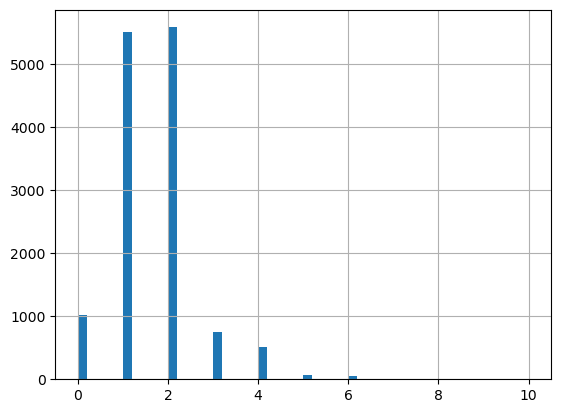

In [5]:
df['Car'].hist(bins=50)

Car tiene pocos valores perdidos y sigue una distribución más o menos normal aunque algo sesgada hacia la derecha, por lo que se imputa la media. 

In [6]:
from sklearn.impute import SimpleImputer
df['Car'] = SimpleImputer(strategy="median").fit_transform(df[['Car']])

YearBuilt tiene un valor muy alto de valores perdidos, pero una correlación relevante (es la 4 variable más correlacionada con Price, aunque con un salto sustancial con las anteriores). El tratamiento de esta característica se realizará es el más susceptible de realizar distintas pruebas para ver cual da mejor resultado. Eliminar sus filas nulas sería la opción más descartable, ya que se perdería mucha información. Se podrían probar imputaciones o la eliminación de la variable. A la hora de valorar la imputación, hay que tener en cuenta que su distribución es muy poco normal, por lo que la media no sería una buena opción. La distribución se puede observar en el histograma de la variable. Se podría probar con la mediana o con la moda, o una imputación con un modelo predictivo.
La opción más conservadora será eliminar la variable.

<Axes: >

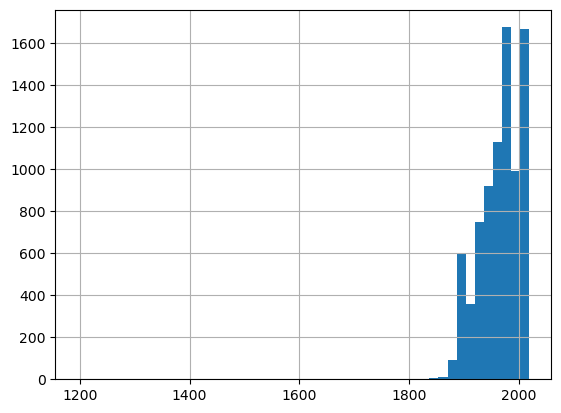

In [7]:
df['YearBuilt'].hist(bins=50)

Columnas categóricas con sus valores únicos:

In [8]:
df.select_dtypes(exclude=[np.number]).nunique()

Suburb           314
Address        13378
Type               3
Method             5
SellerG          268
Date              58
CouncilArea       33
Regionname         8
dtype: int64

Existen varias columnas de información geográfica:
- Address: se elimina por ser un identificador único.
- Suburb: demasiados valores para aplicar One Hot Encoding. Se elimina.
- Regionname: al ser solo 8 valores se puede mantener aplicando One Hot Encoding.

- CouncilArea: tiene valores perdidos y muchos valores únicos. Se puede aplicar OHE si dado que se trata de un dataset pequeño, pero 33 features nuevas pueden ser demasiadas en datasets más grandes, así que eliminarlo también es una opción razonable. También se podría ver la correlación de las columnas tras hacer OHE y valorarlo en función de estos datos.

Una ventaja de aplicar OHE a columnas con valores no disponibles es que se puede tratar la ausencia de valores como una categoría más, lo que puede ser útil en algunos casos.

Hay que tener en cuenta que también se tienen latitud y longitud, que dando una información similar de mayor granularidad apoyan la eliminación de las variables geográficas.

Una opción más avanzada sería realizar un preprocesado de clusterización para ver si se pueden reducir las dimensiones de la información geográfica, en ese caso, sí se podrían contemplar Suburb y CouncilArea, e incluso BuildArea, pero este análisis queda fuera del alcance de este ejercicio.

In [9]:
df.drop(columns=['Address','Suburb','CouncilArea'], inplace=True)

Ante mayor información sobre el significado de SellerG, y Date, se opta por eliminarlas, ya que no se puede aplicar One Hot Encoding por tener demasiados valores únicos. Sin embargo, sería interesante un mayor análisis de estas variables para ver si se pueden extraer más características.

In [10]:
df.drop(columns=['SellerG','Date'], inplace=True)

In [11]:
missing_values_table(df)

,Missing Values,% of Total Values
YearBuilt,5375,39.580265


In [12]:
df.select_dtypes(exclude=[np.number]).nunique()

Type          3
Method        5
Regionname    8
dtype: int64

Para los valores categóricos restantes, se aplicará One Hot Encoding.

In [13]:
df = pd.get_dummies(df,columns=['Type', 'Method', 'Regionname'])
df

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,...,Method_SP,Method_VB,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
0,2,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,-37.79960,...,False,False,False,False,True,False,False,False,False,False
1,2,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,1900.0,-37.80790,...,False,False,False,False,True,False,False,False,False,False
2,3,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,1900.0,-37.80930,...,True,False,False,False,True,False,False,False,False,False
3,3,850000.0,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,-37.79690,...,False,False,False,False,True,False,False,False,False,False
4,4,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,2014.0,-37.80720,...,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,1245000.0,16.7,3150.0,4.0,2.0,2.0,652.0,1981.0,-37.90562,...,False,False,False,False,False,False,True,False,False,False
13576,3,1031000.0,6.8,3016.0,3.0,2.0,2.0,333.0,1995.0,-37.85927,...,True,False,False,False,False,False,False,False,True,False
13577,3,1170000.0,6.8,3016.0,3.0,2.0,4.0,436.0,1997.0,-37.85274,...,False,False,False,False,False,False,False,False,True,False
13578,4,2500000.0,6.8,3016.0,4.0,1.0,5.0,866.0,1920.0,-37.85908,...,False,False,False,False,False,False,False,False,True,False


Como ejemplo para una primera prueba, eliminaremos completamente la columna YearBuilt, tomando la estrategia más sencilla y conservadora.

El problema es de regresión, dado que se busca predecir un valor numérico (Price). Ejemplificaremos con un modelo sencillo de regresión lineal.

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2,random_state=42)

ytrain = train_set['Price']
Xtrain = train_set.drop(columns=['YearBuilt','Price'])

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(Xtrain, ytrain)

Xtest = test_set.drop(columns=['YearBuilt','Price'])
ytest = test_set['Price']

from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, model.predict(Xtest))


270676.27063829935

Comparando con la media (~1M), un error de 270k es bastante alto, aunque la desviación estándar es de 639k, por lo que se podría considerar un error aceptable.

In [15]:
df['Price'].mean().round(), np.round(df['Price'].std())

(1075684.0, 639311.0)

Sin embargo, esta es una primera aproximación y sería razonable hacer otras con distintas estraegias aplicando técnicas de validación cruzada para compararlas y elegir la mejor.